<a href="https://colab.research.google.com/github/yaroslavtsepkov/colab/blob/lab_0/Lab_0_gpu_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU INFO

In [1]:
!nvidia-smi

Sun Nov  1 07:09:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    14W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Matrix multiplication
### CPU (numpy) VS GPU(cupy)


In [78]:
!pip install pycuda
!pip install numba
from numba import cuda, float32
import numpy as np
import cupy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt
from pycuda import driver, compiler, gpuarray, tools
import pycuda.autoinit
from pycuda.tools import make_default_context
import plotly.graph_objects as go
make_default_context().get_device().name()

'Tesla T4'

# Ядро 

In [79]:
kernel_code_template = """
__global__ void MatrixMulKernel(float *a, float *b, float *c)
{
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    float Pvalue = 0;

    for (int k = 0; k < %(MATRIX_SIZE)s; ++k) {
        float Aelement = a[ty * %(MATRIX_SIZE)s + k];
        float Belement = b[k * %(MATRIX_SIZE)s + tx];
        Pvalue += Aelement * Belement;
    }

    c[ty * %(MATRIX_SIZE)s + tx] = Pvalue;
}
"""

In [80]:
def genMatrix(n):
    return np.random.uniform(size=(n,n)).astype(np.float32)

# Перемножение матриц на CPU numpy.matmul

In [81]:
def cpuMult(n):
    size = []
    time_cpu = []
    while n < 2000:
        size.append(n)
        matrix = genMatrix(n)
        s = time.time()
        np.matmul(matrix, matrix)
        p = time.time()
        n += 50
        time_cpu.append(p-s)
    return size, time_cpu

# Перемножение матриц на GPU с cupy.matmul

In [82]:
def gpuMult(n):
    size = []
    time_gpu = []
    while n < 2000:
        size.append(n)
        matrix = cp.array(genMatrix(n))
        s = time.time()
        cp.matmul(matrix, matrix)
        p = time.time()
        n += 50
        time_gpu.append(p-s)
    return size, time_gpu

# Перемножение матриц на GPU pyCUDA

In [83]:
def gpuPyCuda(n):
    size = []
    time_pycuda = []
    while n < 2000:
        size.append(n)
        matrix = genMatrix(n)
        s = time.time()
        matrix = gpuarray.to_gpu(matrix) 
        matrix_result = gpuarray.empty((n, n), np.float32)
        kernel_code = kernel_code_template % {'MATRIX_SIZE': n}  
        mod = compiler.SourceModule(kernel_code)
        matrixmul = mod.get_function("MatrixMulKernel")
        matrixmul(matrix, matrix, matrix_result, block = (32, 32, 1),)
        p = time.time()
        n += 50
        time_pycuda.append(p-s)
    return size, time_pycuda

# Вычисления

In [85]:
startSizeMatrix = 50

In [92]:
size_list_cpu, time_list_cpu = cpuMult(startSizeMatrix)

In [93]:
cp.cuda.Device(0).use()
size_list_gpu, time_list_gpu = gpuMult(startSizeMatrix)

In [94]:
size_list_gpu, time_pycuda = gpuPyCuda(startSizeMatrix)

In [95]:
time_cpu = np.array(time_list_cpu)
time_gpu = np.array(time_list_gpu)
time_pycuda = np.array(time_pycuda)
time_pycuda = np.array(time_numba)

# Анализ и визуализация

In [96]:
df = pd.DataFrame({
    'size_of_matrix': size_list_cpu,
    'time_for_CPU': time_cpu,
    'time_for_GPU_cupy': time_gpu,
    'time_for_GPU_pycuda': time_pycuda,
    'boost cupy & cpu': time_cpu / time_gpu,
    'boost pycuda & cpu': time_cpu / time_pycuda,
    'boost pycuda & cupy': time_pycuda / time_gpu
})
df.head(5)

,size_of_matrix,time_for_CPU,time_for_GPU_cupy,time_for_GPU_pycuda,boost cupy & cpu,boost pycuda & cpu,boost pycuda & cupy
0,50,0.000158,0.002782,0.002612,0.056656,0.060327,0.939145
1,100,0.002642,0.000098,0.001724,27.090465,1.532503,17.677262
2,150,0.001543,0.000067,0.002263,22.862191,0.681770,33.533569
3,200,0.001544,0.000044,0.001211,35.016216,1.275699,27.448649
4,250,0.001937,0.000046,0.001163,41.661538,1.665778,25.010256


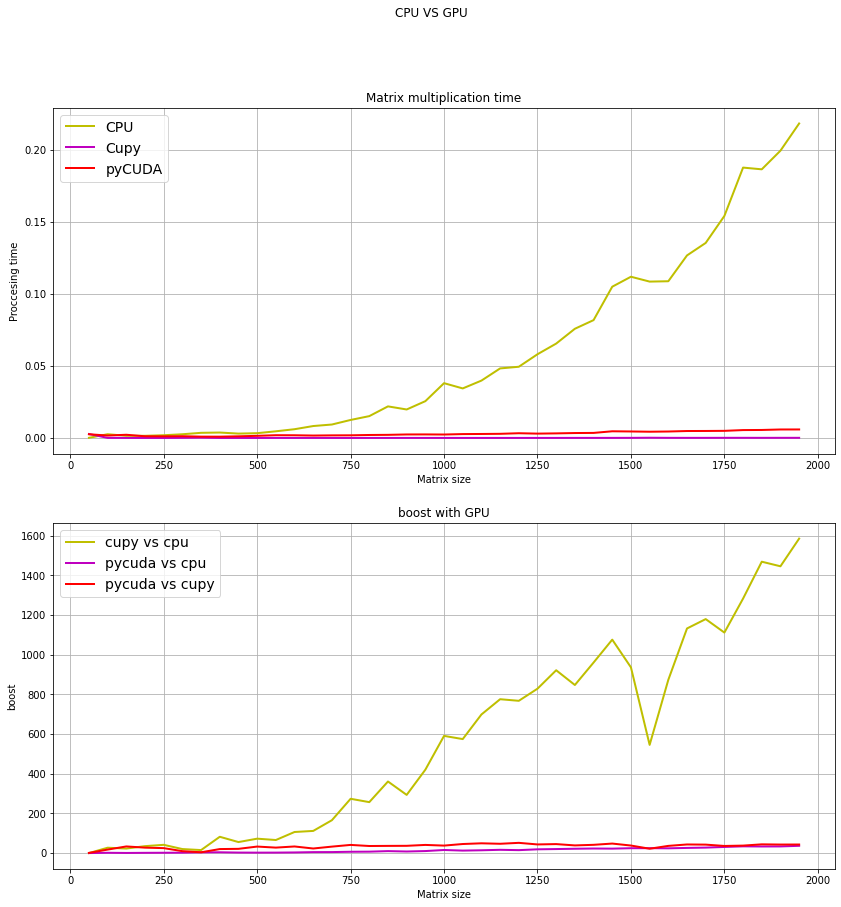

In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,14))
fig.suptitle('CPU VS GPU') 

ax1.plot(df.size_of_matrix, df.time_for_CPU, color='y', label = 'CPU', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_cupy, color='m', label = 'Cupy', linewidth=2)
ax1.plot(df.size_of_matrix, df.time_for_GPU_pycuda, color='r', label = 'pyCUDA', linewidth=2)
ax1.legend(loc="upper left", fontsize=14)
ax1.set_xlabel('Matrix size')
ax1.set_ylabel('Proccesing time')
ax1.set_title('Matrix multiplication time')
ax1.grid()

ax2.plot(df.size_of_matrix, df['boost cupy & cpu'], label = 'cupy vs cpu', color='y', linewidth=2)
ax2.plot(df.size_of_matrix, df['boost pycuda & cpu'],label = 'pycuda vs cpu', color='m', linewidth=2)
ax2.plot(df.size_of_matrix, df['boost pycuda & cupy'],label = 'pycuda vs cupy', color='r', linewidth=2)
ax2.legend(loc="upper left", fontsize=14)
ax2.set_xlabel('Matrix size')
ax2.set_ylabel('boost')
ax2.set_title('boost with GPU')
ax2.grid()


plt.show()

In [98]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_CPU'],
    name='CPU',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_GPU_cupy'],
    name='CUPY',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['time_for_GPU_pycuda'],
    name='PYCUDA',
    mode='lines+markers'
))

In [99]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['boost cupy & cpu'],
    name='CUPY VS CPU',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['boost pycuda & cpu'],
    name='PYCUDA VS CPU',
    mode='lines+markers'
))

fig.add_trace(go.Scatter(
    x=df['size_of_matrix'], y=df['boost pycuda & cupy'],
    name='PYCUDA VS CUPY',
    mode='lines+markers'
))